In [1]:
# imports
import numpy as np
import gym
import imageio
import matplotlib.pyplot as plt
import os

In [2]:
## Task 0. Simple Policy Function
def policy(matrix, weight):
    """
    Computes a policy using the given weight for the provided matrix

    Args:
        matrix: np.ndarray shape (state, action)
        weight: np.ndarray shape (action, weight)

    Returns:
        The policy computed using the given weight
        np.ndarray shape (state, weight)
    """
    dot_prod = matrix.dot(weight)
    exp = np.exp(dot_prod)
    policy = exp / np.sum(exp)
    return policy

In [3]:
# 0-main
weight = np.ndarray((4, 2), buffer=np.array([
    [4.17022005e-01, 7.20324493e-01], 
    [1.14374817e-04, 3.02332573e-01], 
    [1.46755891e-01, 9.23385948e-02], 
    [1.86260211e-01, 3.45560727e-01]
    ]))
state = np.ndarray((1, 4), buffer=np.array([
    [-0.04428214,  0.01636746,  0.01196594, -0.03095031]
    ]))

res = policy(state, weight)
print(res)

[[0.50351642 0.49648358]]


In [4]:
# Task 1. Compute the Monte-Carlo policy gradient
def policy_gradient(state, weight):
    """
    Function that computes the Monte-Carlo policy gradient based on a state
        and a weight matrix

    Args:
        state: matrix representing the current observation of the environment
        weight: matrix of random weight

    Returns:
        The action and the gradieng(in this order)
    """
    MCPolicy = policy(state, weight)
    action = np.random.choice(len(MCPolicy[0]), p=MCPolicy[0])

    # Need to reshape the policy to build softmax, so we do that here
    s = MCPolicy.reshape(-1, 1)

    softmax = (np.diagflat(s) - np.dot(s, s.T))[action, :]

    log_derivative = softmax / MCPolicy[0, action]

    grad = state.T.dot(log_derivative[None, :])

    return action, grad

In [5]:
# 1-main
env = gym.make('CartPole-v1')
np.random.seed(1)

weight = np.random.rand(4, 2)
state = env.reset()[None,:]
print(weight)
print(state)

# Create new state values to match example file to test function
state = np.ndarray((1, 4), buffer=np.array([
    [ 0.04228739, -0.04522399,  0.01190918, -0.03496226]
    ]))

action, grad = policy_gradient(state, weight)
print(action)
print(grad)

env.close()

[[4.17022005e-01 7.20324493e-01]
 [1.14374817e-04 3.02332573e-01]
 [1.46755891e-01 9.23385948e-02]
 [1.86260211e-01 3.45560727e-01]]
[[ 0.02728529 -0.03951451  0.003747   -0.04482423]]
0
[[ 0.02106907 -0.02106907]
 [-0.02253218  0.02253218]
 [ 0.00593357 -0.00593357]
 [-0.01741943  0.01741943]]


In [6]:
# Task 2. Implement the training
def train(env, nb_episodes, alpha=0.000045, gamma=0.98):
    """
    Function that implements a full training of the policy gradient
    Args:
        env: initial environment
        nb_episodes: number of episodes used for training
        alpha: learning rate
        gamma: discount factor

    Returns:
        all values of the score (sum of all rewards during one episode loop)
    """
    # Assign weights randomly based on the given environment
    number_observations = env.observation_space.shape[0]
    number_actions = env.action_space.n
    weight = np.random.rand(number_observations, number_actions)

    # Initialize a list to track scores of episodes
    scores = []

    # Iterate over all episodes
    for episode in range(nb_episodes + 1):
        # Reset the environment and get the initial state
        state = env.reset()[None, :]
        # Empty out gradients / rewards list and reset episode score to 0
        gradients = []
        rewards = []
        episode_score = 0

        done = False

        while not done:  # episode has not ended
            # Get action and gradient from the policy_gradient function
            action, gradient = policy_gradient(state, weight)
            next_state, reward, done, _ = env.step(action)

            # Append gradient and reward to their respective lists
            gradients.append(gradient)
            rewards.append(reward)

            # Add the reward to the episode score
            episode_score += reward

            state = next_state[None, :]

        # Convert rewards to a numpy array
        rewards = np.array(rewards)

        # Update weights using the policy gradient algorithm
        for i in range(len(gradients)):
            learning = (alpha * gradients[i])
            discount = sum(gamma ** rewards[i:] * rewards[i:])
            weight += learning * discount

        # Append the episode's score to scores list
        scores.append(episode_score)

        # Print episode scores
        print("Episode: " + str(episode) + " Score: " + str(episode_score),
              end="\r", flush=False) 

    # Return the list of scores and the list of weights
    return scores


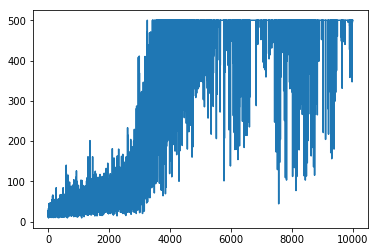

In [7]:
# 2-main
env = gym.make('CartPole-v1')

scores = train(env, 10000)

plt.plot(np.arange(len(scores)), scores)
plt.show()
env.close()

In [8]:
# Task 3. Animate Iteration
# Made a copy of task 2 to run here with rendering certain episodes
# renamed function from train to render
def render(env, nb_episodes, alpha=0.000045, gamma=0.98, show_result=False,
           episodes_to_render=[], save_gifs=False):
    """
    Function that implements a full training of the policy gradient
    Args:
        env: initial environment
        nb_episodes: number of episodes used for training
        alpha: learning rate
        gamma: discount factor

    Returns:
        all values of the score (sum of all rewards during one episode loop)
    """    
    # Assign weights randomly based on the given environment
    number_observations = env.observation_space.shape[0]
    number_actions = env.action_space.n
    weight = np.random.rand(number_observations, number_actions)

    # Initialize a list to track scores of episodes
    scores = []

    # Iterate over all episodes
    for episode in range(nb_episodes + 1):
        # Reset the environment and get the initial state
        state = env.reset()[None, :]
        # Empty out gradients / rewards list and reset episode score to 0
        gradients = []
        rewards = []
        frames = []
        episode_score = 0

        done = False

        while not done:  # episode has not ended
            # Render the game, human format
            if show_result and not save_gifs and episode in episodes_to_render:
                env.render(mode='human')
            # If we want to save gifs, build the frame array
            if show_result and save_gifs and episode in episodes_to_render:
                frame_arr = env.render(mode='rgb_array')
                frames.append(frame_arr)
            # Convert that frame array to a .gif and save locally
            path = "episode_gifs"
            if not os.path.exists(path):
                os.makedirs(path)
            if show_result and save_gifs and episode in episodes_to_render:
                imageio.mimsave(path + '/episode_' + str(episode) + '.gif', 
                                frames, 
                                fps = 16, 
                                )
            # Get action and gradient from the policy_gradient function
            action, gradient = policy_gradient(state, weight)
            next_state, reward, done, _ = env.step(action)

            # Append gradient and reward to their respective lists
            gradients.append(gradient)
            rewards.append(reward)

            # Add the reward to the episode score
            episode_score += reward

            state = next_state[None, :]

        # Convert rewards to a numpy array
        rewards = np.array(rewards)

        # Update weights using the policy gradient algorithm
        for i in range(len(gradients)):
            learning = (alpha * gradients[i])
            discount = sum(gamma ** rewards[i:] * rewards[i:])
            weight += learning * discount

        # Append the episode's score to scores list
        scores.append(episode_score)

        # Print episode scores
        if episode in episodes_to_render:
            print("Episode: " + str(episode) + " Score: " + str(episode_score))

    # Return the list of scores and the list of weights
    return scores

In [9]:
# 3-main
env = gym.make('CartPole-v1')

scores = render(env=env,
                nb_episodes=10000,
                alpha=0.000045,
                gamma=0.98,
                show_result=True,
                episodes_to_render=[0, 250, 500, 1000, 2500, 5000, 10000],
                save_gifs=False,  # When True creates new gifs WILL BE SLOW
                )

env.close()

Episode: 0 Score: 13.0
Episode: 250 Score: 15.0
Episode: 500 Score: 24.0
Episode: 1000 Score: 40.0
Episode: 2500 Score: 138.0
Episode: 5000 Score: 500.0
Episode: 10000 Score: 500.0
